In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.photUtils as photUtils

In [40]:
# Read in the LSST throughput curves
fdir = os.getenv('LSST_THROUGHPUTS_DEFAULT')
print('Reading throughputs from %s' % fdir)
lsst = {}
for f in ['g', 'r', 'i', 'z', 'y']:
    lsst[f] = photUtils.Bandpass()
    lsst[f].readThroughput(os.path.join(fdir, 'total_' + f + '.dat'), wavelen_min=450)

Reading throughputs from /Users/lynnej/lsstRepos/throughputs/baseline/


In [41]:
# Add some V band 
V = photUtils.Bandpass()
V.readThroughput('/Users/lynnej/seds/asteroids/harris_V.dat', wavelen_min=450)
# Add some JHK curves
fdir = os.getenv('THROUGHPUTS_DIR') + '/2MASS'
twomass = {}
for f in ('J', 'H', 'Ks'):
    twomass[f] = photUtils.Bandpass(wavelen_min = 1000, wavelen_max=2400)
    twomass[f].readThroughput(os.path.join(fdir, '2MASS_' + f + '.dat'))

Text(0.5,1,'Throughput curves')

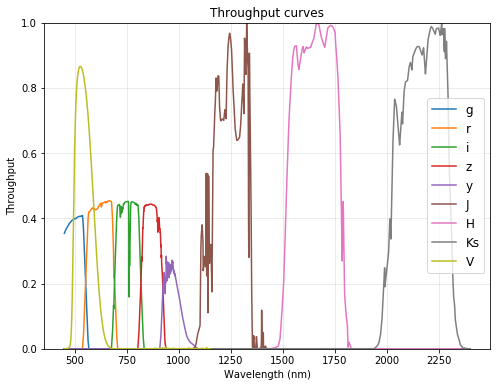

In [42]:
# Show curves
plt.figure(figsize=(8, 6))
for f in lsst:
    plt.plot(lsst[f].wavelen, lsst[f].sb, label=f)
for f in twomass:
    plt.plot(twomass[f].wavelen, twomass[f].sb, label=f)
plt.plot(V.wavelen, V.sb, label='V')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Throughput')
plt.legend(fancybox=True, fontsize='large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.title('Throughput curves')
# I suspect the 2mass curves do not include the atmosphere and possibly not QE from chip.
# Probably similar for the V band curve.
# the LSST curves do.

In [43]:
# Read in asteroid reflectance curves
astfiles = glob.glob('*.txt')
ast_ref = {}
for a in astfiles:
    name = os.path.split(a)[-1].rstrip('.txt')
    ast_ref[name] = photUtils.Sed()
    ast_ref[name].readSED_flambda(a)
    ast_ref[name].wavelen = ast_ref[name].wavelen*1000.0  # convert to nanometers from microns

Text(0.5,1,'Asteroid reflectance spectra')

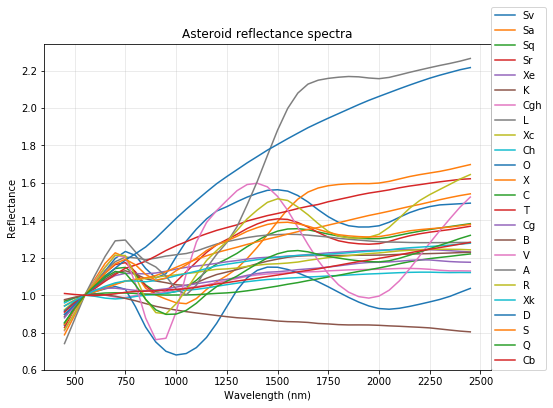

In [44]:
plt.figure(figsize=(8, 6))
for a in ast_ref:
    plt.plot(ast_ref[a].wavelen, ast_ref[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
#plt.xlim(400, 1200)
plt.title('Asteroid reflectance spectra')

Text(0.5,1,'Asteroid reflectance spectra')

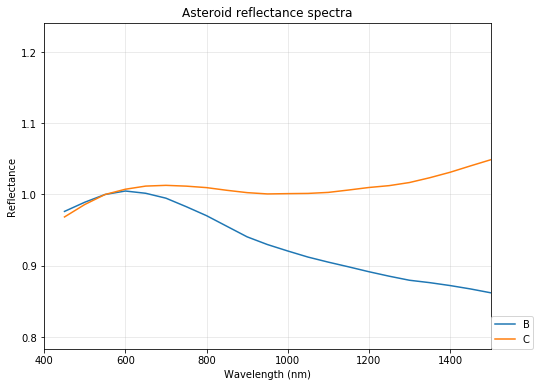

In [45]:
plt.figure(figsize=(8, 6))
for a in ['B', 'C']:
    plt.plot(ast_ref[a].wavelen, ast_ref[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
plt.xlim(400, 1500)
plt.title('Asteroid reflectance spectra')

Text(0,0.5,'Solar flux')

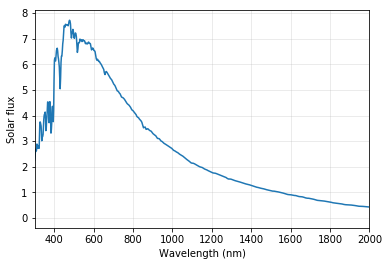

In [46]:
# Add solar spectra
sun = photUtils.Sed()
sun.readSED_flambda('kurucz_sun')
# Just rescale to avoid math overflow
sun.flambda = sun.flambda / 1000000.
plt.plot(sun.wavelen, sun.flambda)
plt.xlim(300, 2000)
plt.grid(True, alpha=0.3)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Solar flux')

In [47]:
asts = {}
for a in ast_ref:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        asts[a] = ast_ref[a].multiplySED(sun)

Text(0.5,1,'Asteroid observed spectra')

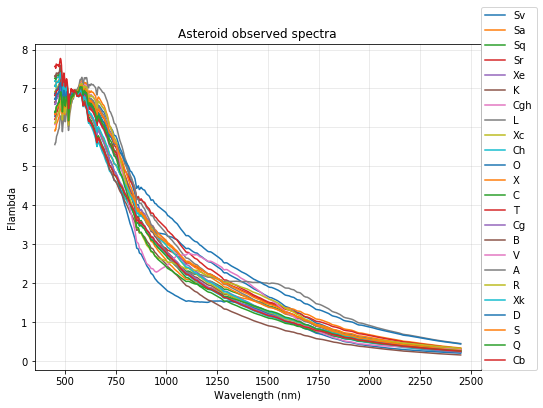

In [48]:
plt.figure(figsize=(8, 6))
for a in asts:
    plt.plot(asts[a].wavelen, asts[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flambda')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
plt.title('Asteroid observed spectra')

Text(0.5,1,'Asteroid observed spectra')

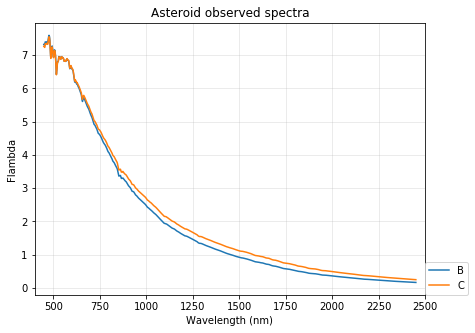

In [49]:
plt.figure(figsize=(7, 5))
for a in ['B', 'C']: 
    plt.plot(asts[a].wavelen, asts[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flambda')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
plt.xlim(400, 2500)
plt.title('Asteroid observed spectra')

In [50]:
# Calculate colors
vmags = {}
for a in asts:
    vmags[a] = asts[a].calcMag(V)
jmags = {}
hmags = {}
kmags = {}
for a in asts:
    jmags[a] = asts[a].calcMag(twomass['J'])
    hmags[a] = asts[a].calcMag(twomass['H'])
    kmags[a] = asts[a].calcMag(twomass['Ks'])
lsstmags = {}
for f in lsst:
    lsstmags[f] = {}
    for a in asts:
        lsstmags[f][a] = asts[a].calcMag(lsst[f])

In [77]:
print('Name \t  V-g  \t  V-r  \t  V-i \t  V-z  \t V-y \t V-J \t  V-H  \t  V-K')
for a in asts:
    writestring = '%s' % a
    for f in lsst:
        vX = vmags[a] - lsstmags[f][a]
        writestring += ' \t%.3f' % (vX)
    vj = vmags[a] - jmags[a]
    vh = vmags[a] - hmags[a]
    vk = vmags[a] - kmags[a]
    writestring += '\t%.3f \t%.3f \t%.3f' % (vj, vh, vk)
    print(writestring)

Name 	  V-g  	  V-r  	  V-i 	  V-z  	 V-y 	 V-J 	  V-H  	  V-K
Sv 	-0.209 	0.261 	0.486 	0.420 	0.455	0.661 	0.539 	0.066
Sa 	-0.242 	0.296 	0.462 	0.328 	0.275	0.358 	0.571 	0.214
Sq 	-0.206 	0.250 	0.416 	0.341 	0.320	0.439 	0.429 	-0.010
Sr 	-0.215 	0.258 	0.435 	0.336 	0.350	0.527 	0.443 	-0.024
Xe 	-0.190 	0.233 	0.399 	0.414 	0.439	0.431 	0.322 	-0.084
K 	-0.191 	0.234 	0.403 	0.380 	0.367	0.374 	0.312 	-0.108
Cgh 	-0.168 	0.177 	0.277 	0.305 	0.331	0.336 	0.239 	-0.175
L 	-0.213 	0.265 	0.472 	0.484 	0.508	0.520 	0.407 	-0.054
Xc 	-0.169 	0.201 	0.357 	0.386 	0.409	0.394 	0.290 	-0.091
Ch 	-0.148 	0.161 	0.267 	0.295 	0.318	0.311 	0.208 	-0.197
O 	-0.171 	0.198 	0.284 	0.059 	-0.088	0.161 	0.208 	-0.382
X 	-0.161 	0.196 	0.355 	0.392 	0.436	0.482 	0.430 	0.097
C 	-0.149 	0.177 	0.290 	0.295 	0.300	0.264 	0.184 	-0.148
T 	-0.179 	0.224 	0.421 	0.481 	0.539	0.582 	0.525 	0.173
Cg 	-0.187 	0.206 	0.319 	0.325 	0.347	0.346 	0.254 	-0.134
B 	-0.146 	0.169 	0.258 	0.234 	0.215	0.121 	

In [76]:
print('Name \t  V-g  \t  V-r  \t  V-i \t  V-z  \t V-y \t V-J \t  V-H  \t  V-K')
for a in ['B', 'C', 'Cg', 'Cgh', 'Ch', 'Cb', 'D']:
    writestring = '%s' % a
    for f in lsst:
        vX = vmags[a] - lsstmags[f][a]
        writestring += ' \t%.3f' % (vX)
    vj = vmags[a] - jmags[a]
    vh = vmags[a] - hmags[a]
    vk = vmags[a] - kmags[a]
    writestring += '\t%.3f \t%.3f \t%.3f' % (vj, vh, vk)
    print(writestring)

Name 	  V-g  	  V-r  	  V-i 	  V-z  	 V-y 	 V-J 	  V-H  	  V-K
B 	-0.146 	0.169 	0.258 	0.234 	0.215	0.121 	-0.068 	-0.527
C 	-0.149 	0.177 	0.290 	0.295 	0.300	0.264 	0.184 	-0.148
Cg 	-0.187 	0.206 	0.319 	0.325 	0.347	0.346 	0.254 	-0.134
Cgh 	-0.168 	0.177 	0.277 	0.305 	0.331	0.336 	0.239 	-0.175
Ch 	-0.148 	0.161 	0.267 	0.295 	0.318	0.311 	0.208 	-0.197
Cb 	-0.133 	0.165 	0.291 	0.310 	0.326	0.316 	0.235 	-0.106
D 	-0.188 	0.240 	0.464 	0.554 	0.646	0.775 	0.794 	0.492


Text(0,0.5,'V-K')

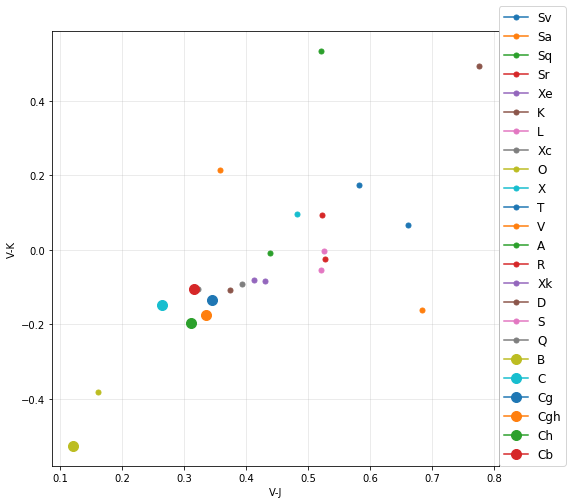

In [72]:
plt.figure(figsize=(8, 8))
specialasts = ['B', 'C', 'Cg', 'Cgh', 'Ch', 'Cb']
for a in asts:
    if a in specialasts:
        continue
    plt.plot(vmags[a] - jmags[a], vmags[a] - kmags[a], marker='o', markersize=5, label=a)
for a in specialasts:
    plt.plot(vmags[a] - jmags[a], vmags[a] - kmags[a], marker='o', markersize=10, label=a)
plt.legend(loc=(1, 0.), fancybox=True, fontsize='large')
plt.grid(True, alpha=0.3)
plt.xlabel('V-J')
plt.ylabel('V-K')